<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/hydrogen/transportOfHydrogen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
#@title Transport of hydrogen
#@markdown This page will give an introduction to transport of hydrogen.
#@markdown <br><br>This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
%%capture
!pip install neqsim==2.5.35
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('classic')
%matplotlib inline

#Litterature

https://www.equinor.com/en/what-we-do/hydrogen.html

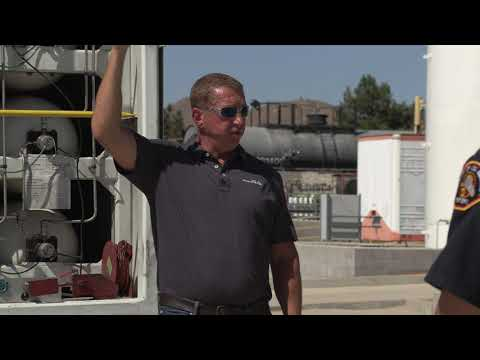

In [32]:
#@title Introduction to transport of hydrogen
from IPython.display import YouTubeVideo
YouTubeVideo('LsYq9jRkXsg', width=600, height=400)

#Pipeline transport of hydrogen

Hydrogen Transportation in Pipelines
Hydrogen transportation through pipelines is a feasible option, but it comes with certain challenges and considerations.

* Pipeline Material
The pipeline material must be able to withstand the high pressure and low temperature of hydrogen. Some metals may become embrittled due to hydrogen, so other pipeline materials like steel, plastic, and composite materials should be considered based on cost, operating conditions, and safety requirements.

* Pipeline Design
Designing pipelines to prevent hydrogen leakage is a critical safety requirement. Choosing reliable design features such as welded joints, fittings, and valves can ensure safe operation.

* Compression and Decompression
Hydrogen needs to be compressed to high pressures to move it over long distances, which requires energy and can result in some loss of the product due to compression heating. At the destination, the hydrogen must be decompressed, which also requires energy and can result in cooling of the product.

* Safety Considerations
Hydrogen is a flammable gas and must be handled with care to prevent ignition and explosion. Pipeline operators must have strict safety protocols in place to prevent accidents, and emergency response plans must be developed in case of an incident.

In [33]:
from neqsim.thermo import fluid, TPflash

fluid1 = fluid('pr')
fluid1.addComponent('hydrogen', 1.0)
fluid1.addComponent('methane', 0.0)
fluid1.setPressure(1.01325, 'bara')
fluid1.setTemperature(20.0, 'C')

TPflash(fluid1);
fluid1.initProperties()
print('buble point temperature', fluid1.getTemperature('C'), " at ", fluid1.getPressure(), " bara")
print('gas density ', fluid1.getPhase('gas').getDensity())
print('density ', fluid1.getDensity())

method = "friction theory"
fluid1.getPhase('gas').getPhysicalProperties().setViscosityModel(method)

buble point temperature 20.0  at  1.01325  bara
gas density  0.08378487036468386
density  0.08378487036468386


# Compression of hydrogen

In [43]:
from neqsim import methods
from neqsim.thermo import fluid, TPflash, createfluid2
from neqsim.process import pipe, pipeline, clearProcess, stream, runProcess, compressor,heater

pressureExport = 150.0 #@param {type:"number"}
temperatureExport = 35.0 #@param {type:"number"}

clearProcess()
stream1 = stream(fluid1)

stream1.setFlowRate(130.0, "MSm3/day")
stream1.setTemperature(20.15, "C")
stream1.setPressure(90.0, "bara")

compressor_1 = compressor(stream1, 120.0)
compressor_1.setIsentropicEfficiency(0.77)
coolerMP1 = heater(compressor_1.getOutStream())
coolerMP1.setOutTemperature(20.0+273.15)
compressor_2 = compressor(coolerMP1.getOutStream(), pressureExport)
compressor_2.setIsentropicEfficiency(0.77)
coolerExport = heater(compressor_2.getOutStream())
coolerExport.setOutTemperature(temperatureExport+273.15)
runProcess()

print("compressor1 power ", compressor_1.getPower()/1e6, " MW")
print("compressor2 power ", compressor_2.getPower()/1e6, " MW")

print("cooler1 duty ", coolerMP1.getDuty()/1e6, " MW")
print("cooler2 duty ", coolerExport.getDuty()/1e6, " MW")

compressor1 power  62.677301375199555  MW
compressor2 power  48.73870022018932  MW
cooler1 duty  -62.65826537718139  MW
cooler2 duty  -20.0442837192593  MW


In [44]:
printFrame(coolerExport.getOutStream().getFluid())

| 0                  | 1          | 2           | 3   | 4   | 5   | 6               |
|:-------------------|:-----------|:------------|:----|:----|:----|:----------------|
|                    | total      | gas         |     |     |     |                 |
| hydrogen           | 1E0        | 1E0         |     |     |     | [mole fraction] |
| methane            | 0E0        | 0E0         |     |     |     | [mole fraction] |
|                    |            |             |     |     |     |                 |
| Density            |            | 1.08551E1   |     |     |     | [kg/m^3]        |
| PhaseFraction      |            | 1E0         |     |     |     | [mole fraction] |
| MolarMass          | 2.016E0    | 2.016E0     |     |     |     | [kg/kmol]       |
| Z factor           |            | 1.05603E0   |     |     |     | [-]             |
| Heat Capacity (Cp) |            | 1.46332E1   |     |     |     | [kJ/kg*K]       |
| Heat Capacity (Cv) |            | 1.01772E1   |     

# Transport of hydrogen in pipeline

In [45]:
diameter = [0.98, 0.98] #meter
roughnes = [5.0e-6, 5.0e-6] #meter
position = [0.0, 500000.0] #meter
height = [0.0, 0.0] #meter
outtemperatures =[278.15, 278.15] #Kelvin
outHeatU = [25.0, 25.0] #W/m2K
wallHeatU = [35.0, 35.0] #W/m2K

print(coolerExport.getOutStream().getFlowRate('MSm3/day'))

clearProcess()
pipe1 = pipeline(coolerExport.getOutStream(), position, diameter, height, outtemperatures, roughnes,outHeatU,wallHeatU)
pipe1.setNumberOfNodesInLeg(100)
runProcess()

numberofnodes = pipe1.getPipe().getTotalNumberOfNodes()

print('number of nodes ' , numberofnodes)
print('outlet pressure ', pipe1.getPipe().getNode(numberofnodes-1).getBulkSystem().getPressure('bara'))
print('outlet temperature ', pipe1.getPipe().getNode(numberofnodes-1).getBulkSystem().getTemperature('C'))

130.0
number of nodes  102
outlet pressure  84.55103958296226
outlet temperature  5.156214903892533


pressure out of pipeline  83.99771826987052 [bara]
| 0                  | 1          | 2                  | 3   | 4   | 5   | 6               |
|:-------------------|:-----------|:-------------------|:----|:----|:----|:----------------|
|                    | total      | gas                |     |     |     |                 |
| hydrogen           | 1E0        | 1E0                |     |     |     | [mole fraction] |
| methane            | 0E0        | 0E0                |     |     |     | [mole fraction] |
|                    |            |                    |     |     |     |                 |
| Density            |            | 6.98214E0          |     |     |     | [kg/m^3]        |
| PhaseFraction      |            | 1E0                |     |     |     | [mole fraction] |
| MolarMass          | 2.016E0    | 2.016E0            |     |     |     | [kg/kmol]       |
| Z factor           |            | 1.02832E0          |     |     |     | [-]             |
| Heat Capacity (Cp

Text(0, 0.5, 'Temperature [C]')

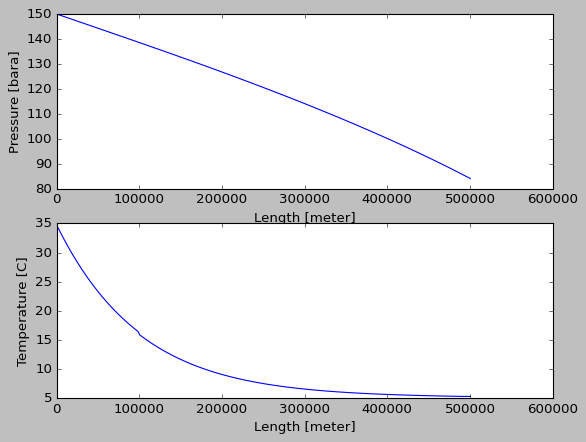

In [47]:
diameter = [1.0, 1.0, 1.0]
roughness = [15.0e-6, 15.0e-6, 15.0e-6]
position = [0.0, 100000.0, 500000.0]
elevation = [0.0, 0.0, 0.0]
outtemperatures =[278.15, 278.15, 278.15]
outHeatU = [15.0, 15.0, 15.0]
wallHeatU = [15.0, 15.0, 15.0]

clearProcess()
stream1 = stream(coolerExport.getOutStream())
pipe1 = pipeline(stream1, position, diameter, elevation, outtemperatures, roughness, outHeatU,wallHeatU)
runProcess()

print('pressure out of pipeline ', pipe1.getOutStream().getFluid().getPressure('bara'), '[bara]')
printFrame(pipe1.getOutStream().getFluid())

length = []
pressure = []
temperature = []
lengthtot = 0.0
for i in range(pipe1.getPipe().getTotalNumberOfNodes()):
  length.append(lengthtot);
  lengthtot = lengthtot+pipe1.getPipe().getNode(i).getLengthOfNode()
  pressure.append(pipe1.getPipe().getNode(i).getBulkSystem().getPressure('bara'))
  temperature.append(pipe1.getPipe().getNode(i).getBulkSystem().getTemperature('C'))

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(length, pressure)
plt.xlabel('Length [meter]')
plt.ylabel('Pressure [bara]')
plt.subplot(2, 1, 2)
plt.plot(length, temperature)
plt.xlabel('Length [meter]')
plt.ylabel('Temperature [C]')

# Heat of combustion

The heat of combustion of hydrogen is significantly higher than that of natural gas.

The heat of combustion is the amount of heat released when a substance is burned. For hydrogen, the heat of combustion is about 141.8 MJ/kg, while for natural gas it is around 55.5 MJ/kg.

This means that when hydrogen is burned, it releases more than twice as much heat per unit of mass compared to natural gas. This high heat release is one of the advantages of using hydrogen as a fuel, as it can provide more energy per unit of fuel compared to natural gas.

However, it is important to note that the energy density of hydrogen is lower than that of natural gas, which means that a larger volume of hydrogen is required to provide the same amount of energy as natural gas. This can be a challenge for hydrogen storage and transportation, but ongoing research is exploring ways to overcome this limitation.

In [48]:
from neqsim.standards import ISO6976
referenceTemperatureVolume = "15.0" #@param ['0.0', '15.0', '20.0']
referenceTemperatureCombustion = 15.0 #@param ['0.0', '15.0', '20.0']
numberUnit = 'mass' #@param ['volume', 'mass', 'molar']

iso6976 = ISO6976(fluid1)
iso6976.setReferenceType(numberUnit)
iso6976.setVolRefT(float(referenceTemperatureVolume))
iso6976.setEnergyRefT(float(referenceTemperatureCombustion))
iso6976.calculate()

GCV = round(iso6976.getValue("SuperiorCalorificValue")/1.0e3,3)
WI = round(iso6976.getValue("SuperiorWobbeIndex")/1.0e3,3)
WIkwh = round(iso6976.getValue("SuperiorWobbeIndex")/1.0e3/3.6,3)
relDens = round(iso6976.getValue("RelativeDensity"),3)

print('GCV '+ str(GCV) + ' MJ/' +numberUnit)
print('WI '+ str(WI), ' MJ/' +numberUnit)
print('WI '+ str(WIkwh), ' kWh/' +numberUnit)
print('Relative density '+ str(relDens), ' [-]')

GCV 141.947 MJ/mass
WI 538.173  MJ/mass
WI 149.492  kWh/mass
Relative density 0.07  [-]
